In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import fiona
from shapely.geometry import shape, mapping
import rasterio.features

# 加载非泥炭地火灾数据
non_peatland_df = pd.read_excel('non peatland.xlsx')
non_peatland_df.columns = ['Month', 'Fire Counts', 'Total FRP']
non_peatland_df['Month'] = pd.to_datetime(non_peatland_df['Month'], format='%m-%Y')
non_peatland_df.set_index('Month', inplace=True)

# 加载泥炭地火灾数据
peatland_df = pd.read_excel('peatland.xlsx')
peatland_df.columns = ['Month', 'Fire Counts', 'Total FRP']
peatland_df['Month'] = pd.to_datetime(peatland_df['Month'], format='%m-%Y')
peatland_df.set_index('Month', inplace=True)

# 数据过滤
start_date = '2015-06-01'
end_date = '2023-12-31'
peatland_df_filtered = peatland_df.loc[start_date:end_date]
non_peatland_df_filtered = non_peatland_df.loc[start_date:end_date]

# 加载土壤湿度NetCDF文件
smap_data = xr.open_dataset('SMAP_monthly_mean_soil_moisture_indonesia.nc')['soil_moisture_monthly_mean_indonesia']

# 打开shapefile文件并转换几何形状
with fiona.open('Indonesia_Peat_Lands.shp') as src:
    peat_land_geoms = [shape(feature['geometry']) for feature in src]

# 定义目标网格
transform = rasterio.transform.from_bounds(
    smap_data.lon.min().item(), smap_data.lat.min().item(),
    smap_data.lon.max().item(), smap_data.lat.max().item(),
    smap_data.sizes['lon'], smap_data.sizes['lat']
)

# 手动裁剪数据数组
def manual_clip(da, shapes, transform):
    mask = np.zeros((da.sizes['lat'], da.sizes['lon']), dtype=bool)
    for geom in shapes:
        geom_mask = rasterio.features.geometry_mask([mapping(geom)], 
                                                    transform=transform, 
                                                    invert=True, 
                                                    out_shape=(da.sizes['lat'], da.sizes['lon']))
        mask = mask | geom_mask
    return da.where(mask)

# 裁剪泥炭地土壤湿度数据
soil_moisture_peat_manual = manual_clip(smap_data, peat_land_geoms, transform)

# 裁剪非泥炭地土壤湿度数据
soil_moisture_non_peat_manual = smap_data.where(~soil_moisture_peat_manual.notnull())

# 选择时间范围，从2015年到2023年
soil_moisture_peat_manual = soil_moisture_peat_manual.sel(time=slice('2015-01-01', '2023-12-31'))
soil_moisture_non_peat_manual = soil_moisture_non_peat_manual.sel(time=slice('2015-01-01', '2023-12-31'))

# 绘制图像
fig, ax1 = plt.subplots(figsize=(21, 10), dpi=600)

# 绘制火灾数量变化曲线图
ax1.plot(non_peatland_df_filtered.index, non_peatland_df_filtered['Fire Counts'], label='Non-Peatland Fire Counts', color='orange', linewidth=3)
ax1.plot(peatland_df_filtered.index, peatland_df_filtered['Fire Counts'], label='Peatland Fire Counts', color='blue', linewidth=3)
ax1.set_xlabel('Month', fontsize=25)
ax1.set_ylabel('Fire Counts', fontsize=25, color='black')
ax1.tick_params(axis='y', labelsize=20, width=2)
ax1.tick_params(axis='x', labelsize=20, width=2)
ax1.legend(loc='upper left', fontsize=15,framealpha=0.0)
ax1.grid(True)

# 创建第二个y轴
ax2 = ax1.twinx()
ax2.plot(soil_moisture_peat_manual['time'], soil_moisture_peat_manual.mean(['lon', 'lat']), label='Peat Lands Soil Moisture', color='blue', linestyle='-.', linewidth=3)
ax2.plot(soil_moisture_non_peat_manual['time'], soil_moisture_non_peat_manual.mean(['lon', 'lat']), label='Non-Peat Lands Soil Moisture', color='orange', linestyle='-.', linewidth=3)
ax2.set_ylabel('Soil Moisture (m³/m³)', fontsize=25,color='black')
ax2.tick_params(axis='y', labelsize=20, width=2)
ax2.set_ylim([0.2, 0.55])
ax2.legend(loc='upper right', fontsize=15,framealpha=0.0)

# 设置标题
#fig.suptitle('Monthly Fire Counts and Soil Moisture in Peatland and Non-Peatland Areas', fontsize=15)

# 自动调整图像布局
fig.tight_layout()

# 保存图像
plt.savefig('F6-1.png', dpi=600, bbox_inches='tight')
plt.show()




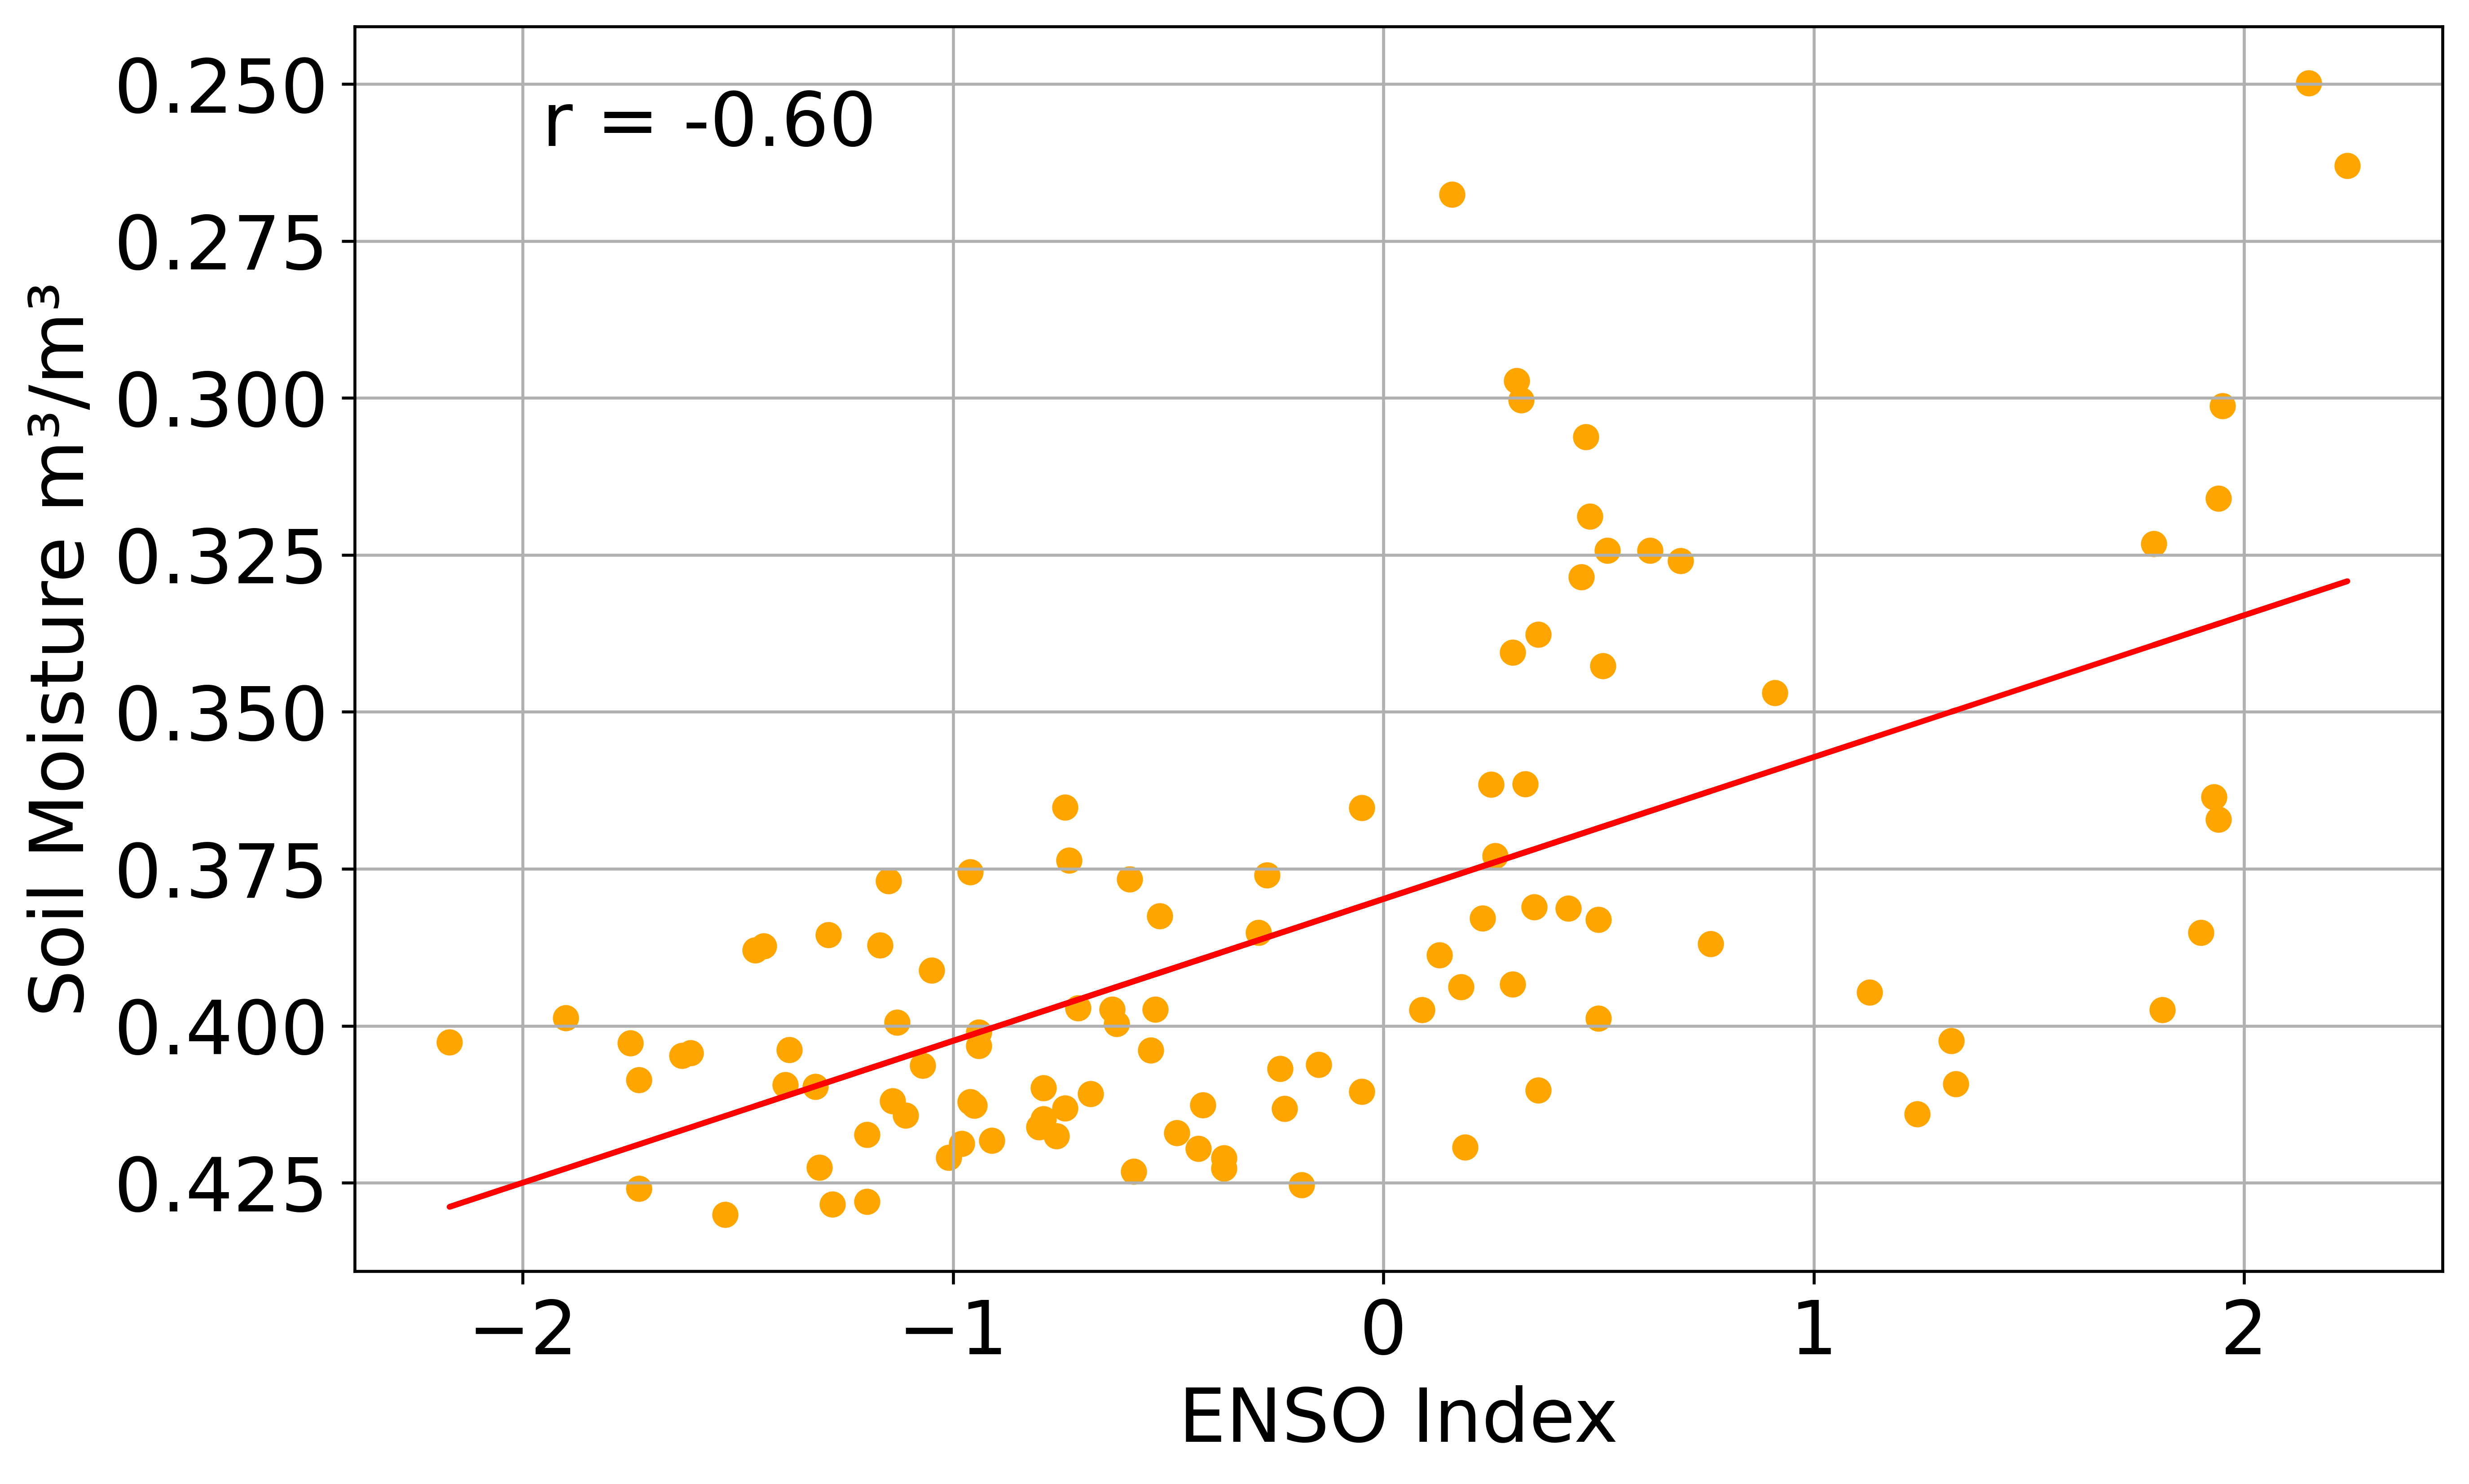

In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# 1. 加载Excel数据
viirs_df = pd.read_excel('data.xlsx')

# 2. 清理和处理VIIRS数据
viirs_df.columns = ['Month', 'MODIS Fire Count', 'MODIS Total FRP', 'VIIRS Fire Count', 'VIIRS Total FRP', 'ENSO index', 'IOD index']
viirs_df = viirs_df[1:]  # 移除标题行
viirs_df['Month'] = pd.to_datetime(viirs_df['Month'], format='%m-%Y')
viirs_df.set_index('Month', inplace=True)
viirs_df = viirs_df.astype(float)

# 从2015年7月开始筛选VIIRS数据
viirs_df_filtered = viirs_df[viirs_df.index >= '2015-06']

# 加载并处理SMAP数据，获取印度尼西亚地区的月平均土壤湿度
smap_ds = xr.open_dataset('SMAP_monthly_mean_soil_moisture_indonesia.nc')
smap_data = smap_ds['soil_moisture_monthly_mean_indonesia'].mean(dim=['lat', 'lon']).to_dataframe()

# 筛选SMAP数据，从2015年7月开始
smap_data_filtered = smap_data[smap_data.index >= '2015-06']

# 调整VIIRS的时间索引到每月月底，以匹配SMAP数据
viirs_df_filtered.index = viirs_df_filtered.index + pd.offsets.MonthEnd(0)

# 重新对齐两个数据集
aligned_smap_enso = pd.merge(smap_data_filtered, viirs_df_filtered[['ENSO index']], left_index=True, right_index=True)

# 计算皮尔逊相关系数
pearson_corr, _ = pearsonr(aligned_smap_enso['soil_moisture_monthly_mean_indonesia'], aligned_smap_enso['ENSO index'])

# 进行线性回归
slope, intercept, r_value, p_value, std_err = linregress(
    aligned_smap_enso['ENSO index'], 
    aligned_smap_enso['soil_moisture_monthly_mean_indonesia']
)

# 画出散点图和回归线
plt.figure(figsize=(10, 6), dpi=600)
plt.scatter(aligned_smap_enso['ENSO index'], aligned_smap_enso['soil_moisture_monthly_mean_indonesia'], color='orange', label='Data Points')
plt.plot(aligned_smap_enso['ENSO index'], 
         slope * aligned_smap_enso['ENSO index'] + intercept, 
         color='red', label=f'Regression Line (Pearson r={pearson_corr:.2f})')

# 添加皮尔逊相关系数文本
plt.text(
    0.25, 0.95, f'r = {pearson_corr:.2f}', 
    horizontalalignment='right', 
    verticalalignment='top', 
    transform=plt.gca().transAxes,
    fontsize=20, 
    bbox=dict(facecolor='none', alpha=0.5, edgecolor='none')
)

plt.xlabel('ENSO Index',fontsize=20)
plt.ylabel('Soil Moisture m³/m³',fontsize=20)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()  # 反转Y轴
plt.grid(True)
plt.savefig(f'F6a.png', dpi=600, bbox_inches='tight')
plt.show()


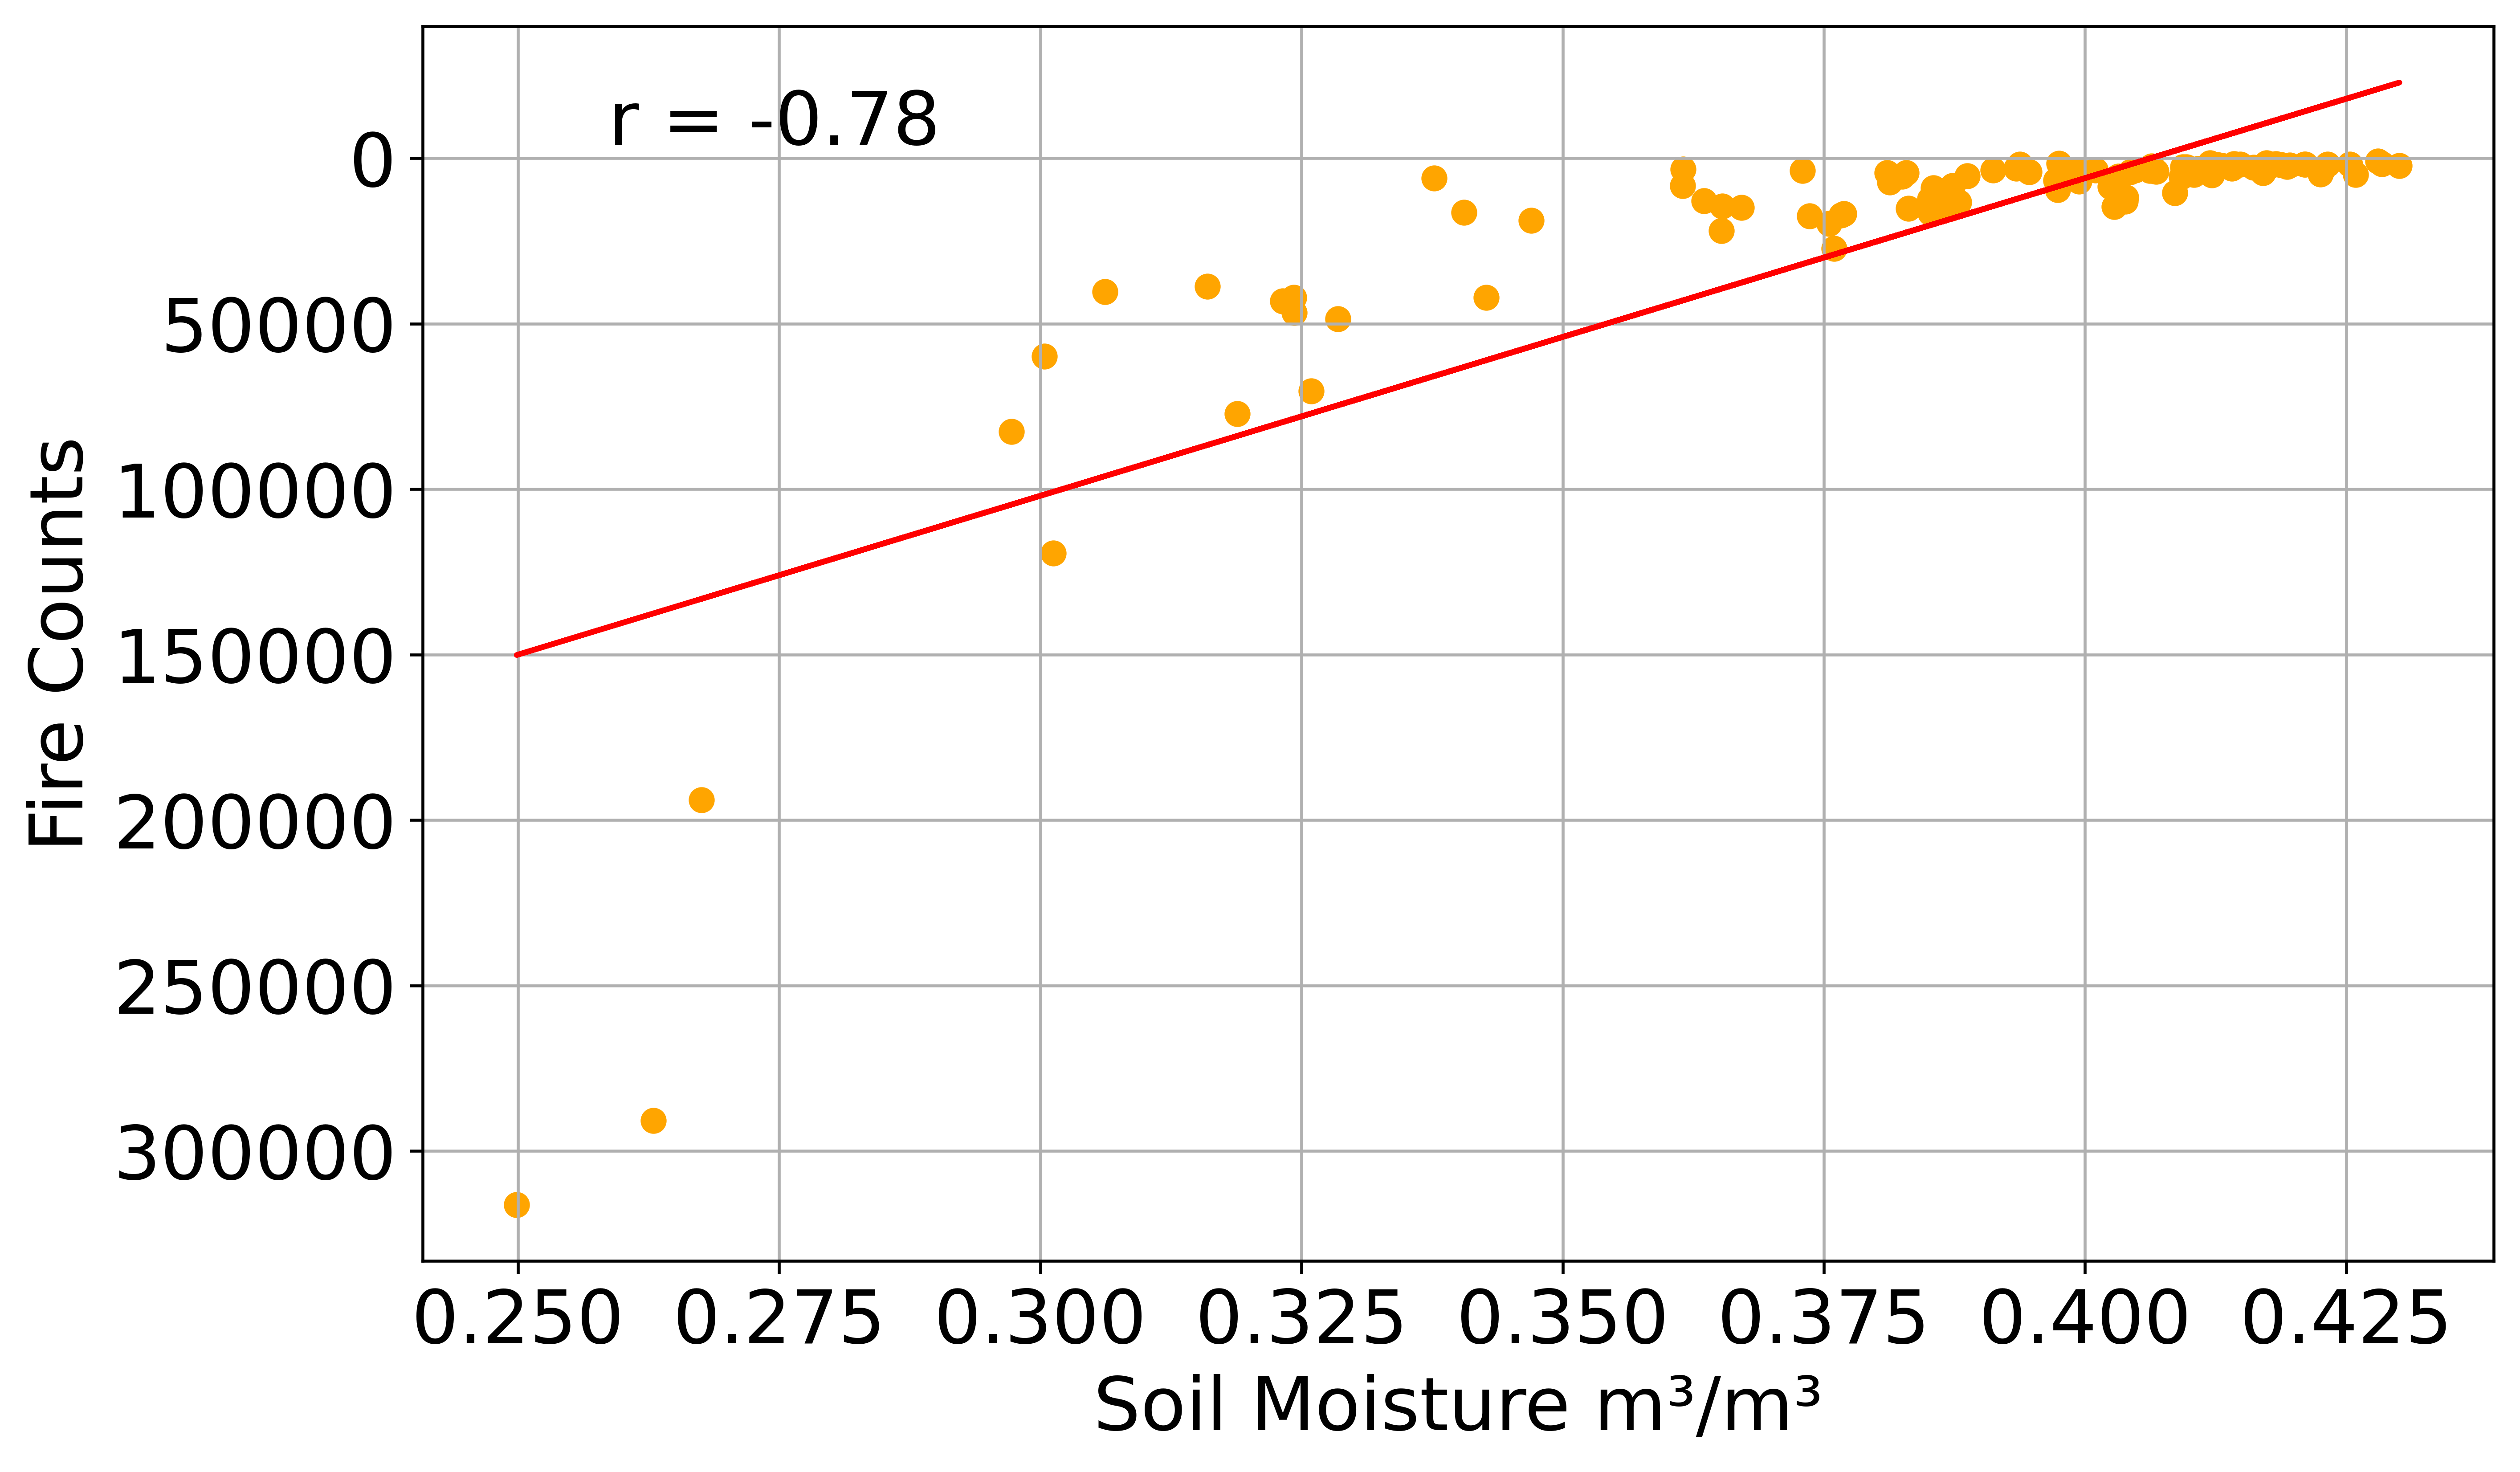

In [2]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# 1. 加载Excel数据
viirs_df = pd.read_excel('data.xlsx')

# 2. 清理和处理VIIRS数据
viirs_df.columns = ['Month', 'MODIS Fire Count', 'MODIS Total FRP', 'VIIRS Fire Count', 'VIIRS Total FRP', 'ENSO index', 'IOD index']
viirs_df = viirs_df[1:]  # 移除标题行
viirs_df['Month'] = pd.to_datetime(viirs_df['Month'], format='%m-%Y')
viirs_df.set_index('Month', inplace=True)
viirs_df = viirs_df.astype(float)

# 从2015年7月开始筛选VIIRS数据
viirs_df_filtered = viirs_df[viirs_df.index >= '2015-06']

# 加载并处理SMAP数据，获取印度尼西亚地区的月平均土壤湿度
smap_ds = xr.open_dataset('SMAP_monthly_mean_soil_moisture_indonesia.nc')
smap_data = smap_ds['soil_moisture_monthly_mean_indonesia'].mean(dim=['lat', 'lon']).to_dataframe()

# 筛选SMAP数据，从2015年6月开始
smap_data_filtered = smap_data[smap_data.index >= '2015-06']

# 调整VIIRS的时间索引到每月月底，以匹配SMAP数据
viirs_df_filtered.index = viirs_df_filtered.index + pd.offsets.MonthEnd(0)

# 重新对齐两个数据集
aligned_viirs_smap_corrected = pd.merge(smap_data_filtered, viirs_df_filtered[['VIIRS Fire Count']], left_index=True, right_index=True)

# 计算皮尔逊相关系数
pearson_corr, _ = pearsonr(aligned_viirs_smap_corrected['soil_moisture_monthly_mean_indonesia'], aligned_viirs_smap_corrected['VIIRS Fire Count'])

# 进行线性回归
slope_corrected, intercept_corrected, r_value_corrected, p_value_corrected, std_err_corrected = linregress(
    aligned_viirs_smap_corrected['soil_moisture_monthly_mean_indonesia'], 
    aligned_viirs_smap_corrected['VIIRS Fire Count']
)
    
# 画出散点图和回归线
plt.figure(figsize=(10, 6), dpi=600)
plt.scatter(aligned_viirs_smap_corrected['soil_moisture_monthly_mean_indonesia'], aligned_viirs_smap_corrected['VIIRS Fire Count'], color='orange', label='Data Points')
plt.plot(aligned_viirs_smap_corrected['soil_moisture_monthly_mean_indonesia'], 
         slope_corrected * aligned_viirs_smap_corrected['soil_moisture_monthly_mean_indonesia'] + intercept_corrected, 
         color='red', 
         label=f'Regression Line (Pearson r={pearson_corr:.2f})')

# 添加皮尔逊相关系数文本
plt.text(
    0.25, 0.95, f'r = {pearson_corr:.2f}', 
    horizontalalignment='right', 
    verticalalignment='top', 
    transform=plt.gca().transAxes,
    fontsize=20, 
    bbox=dict(facecolor='none', alpha=0.5, edgecolor='none')
)

plt.xlabel('Soil Moisture m³/m³', fontsize=20)
plt.ylabel('Fire Counts', fontsize=20)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()  # 反转Y轴
plt.grid(True)
plt.savefig('F6b.png', dpi=600, bbox_inches='tight')
plt.show()


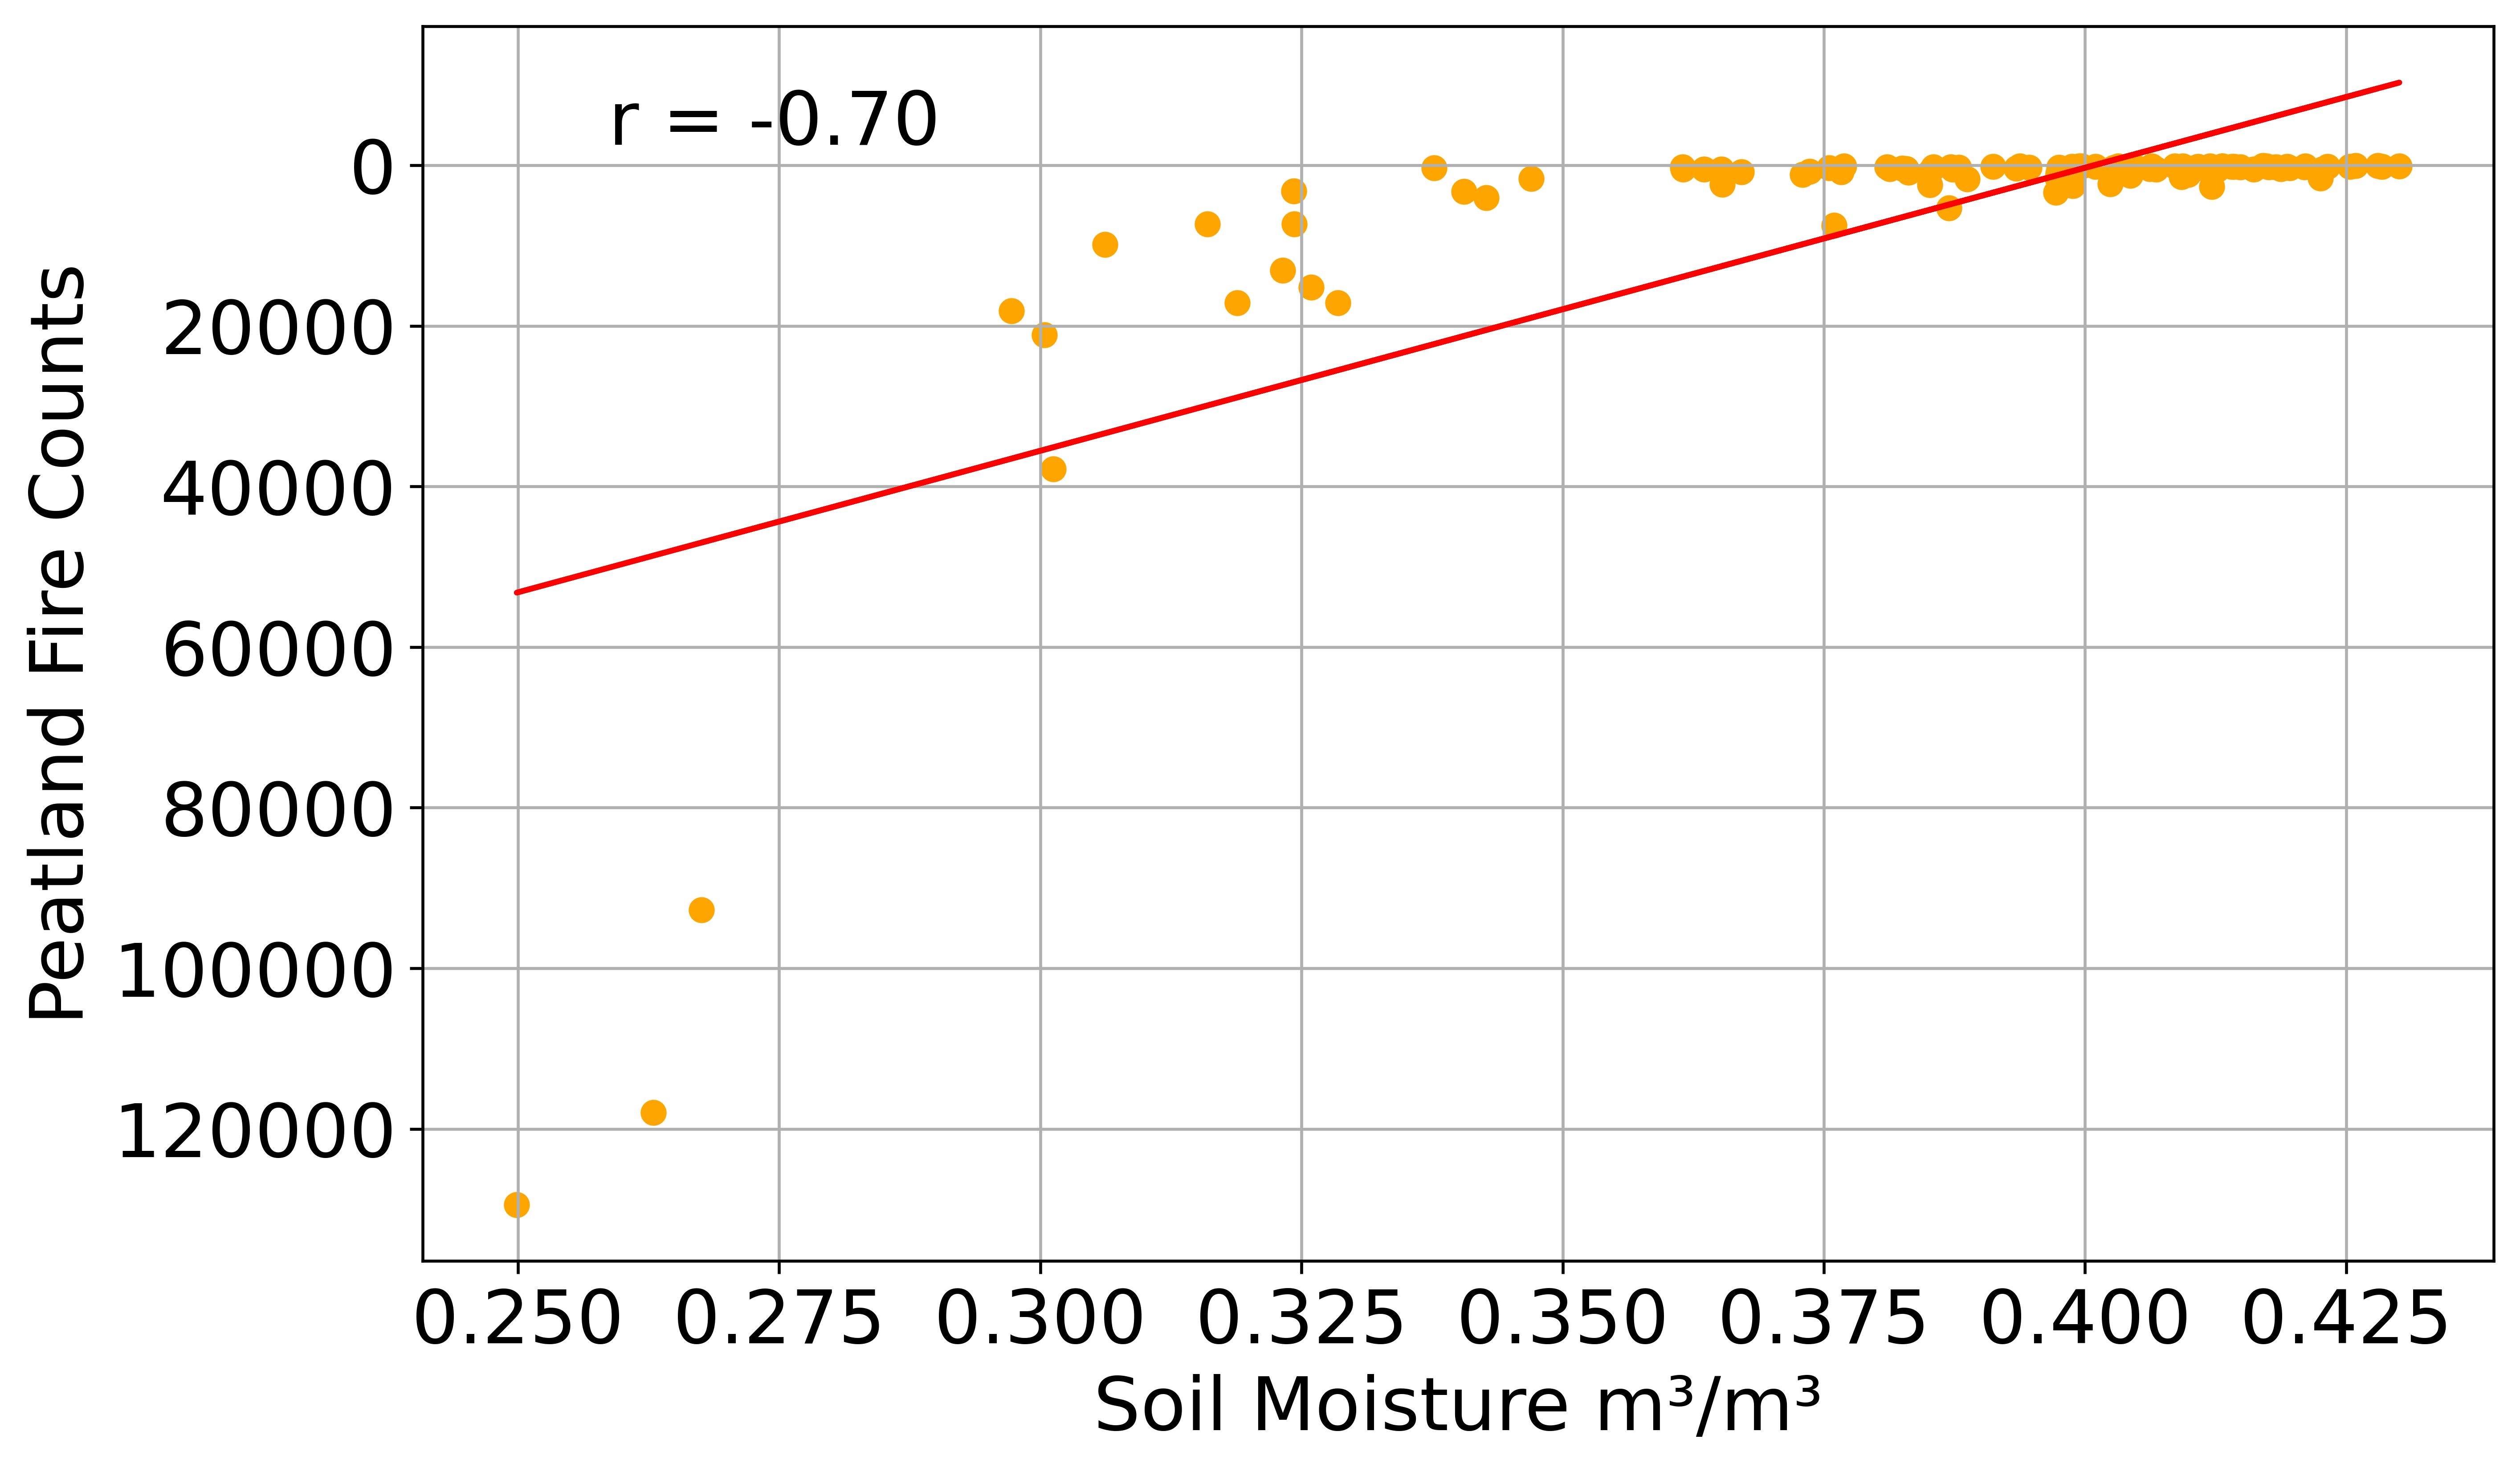

In [3]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# 1. 加载Excel数据
peatland_df = pd.read_excel('peatland.xlsx')

# 2. 清理和处理VIIRS数据
peatland_df.columns = ['Month', 'Fire Counts', 'Total FRP']
peatland_df['Month'] = pd.to_datetime(peatland_df['Month'], format='%m-%Y')
peatland_df.set_index('Month', inplace=True)
peatland_df = peatland_df.astype(float)

# 从2015年7月开始筛选VIIRS数据
peatland_df_filtered = peatland_df[peatland_df.index >= '2015-06']

# 加载并处理SMAP数据，获取印度尼西亚地区的月平均土壤湿度
smap_ds = xr.open_dataset('SMAP_monthly_mean_soil_moisture_indonesia.nc')
smap_data = smap_ds['soil_moisture_monthly_mean_indonesia'].mean(dim=['lat', 'lon']).to_dataframe()

# 筛选SMAP数据，从2015年6月开始
smap_data_filtered = smap_data[smap_data.index >= '2015-06']

# 调整VIIRS的时间索引到每月月底，以匹配SMAP数据
peatland_df_filtered.index = peatland_df_filtered.index + pd.offsets.MonthEnd(0)

# 重新对齐两个数据集
aligned_peatland_smap_corrected = pd.merge(smap_data_filtered, peatland_df_filtered[['Fire Counts']], left_index=True, right_index=True)

# 计算皮尔逊相关系数
pearson_corr, _ = pearsonr(aligned_peatland_smap_corrected['soil_moisture_monthly_mean_indonesia'], aligned_peatland_smap_corrected['Fire Counts'])

# 进行线性回归
slope_corrected, intercept_corrected, r_value_corrected, p_value_corrected, std_err_corrected = linregress(
    aligned_peatland_smap_corrected['soil_moisture_monthly_mean_indonesia'], 
    aligned_peatland_smap_corrected['Fire Counts']
)
    
# 画出散点图和回归线
plt.figure(figsize=(10, 6), dpi=600)
plt.scatter(aligned_peatland_smap_corrected['soil_moisture_monthly_mean_indonesia'], aligned_peatland_smap_corrected['Fire Counts'], color='orange', label='Data Points')
plt.plot(aligned_peatland_smap_corrected['soil_moisture_monthly_mean_indonesia'], 
         slope_corrected * aligned_peatland_smap_corrected['soil_moisture_monthly_mean_indonesia'] + intercept_corrected, 
         color='red', 
         label=f'Regression Line (Pearson r={pearson_corr:.2f})')

# 添加皮尔逊相关系数文本
plt.text(
    0.25, 0.95, f'r = {pearson_corr:.2f}', 
    horizontalalignment='right', 
    verticalalignment='top', 
    transform=plt.gca().transAxes,
    fontsize=20, 
    bbox=dict(facecolor='none', alpha=0.5, edgecolor='none')
)

plt.xlabel('Soil Moisture m³/m³', fontsize=20)
plt.ylabel('Peatland Fire Counts', fontsize=20)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()  # 反转Y轴
plt.grid(True)
plt.savefig('F6c.png', dpi=600, bbox_inches='tight')
plt.show()


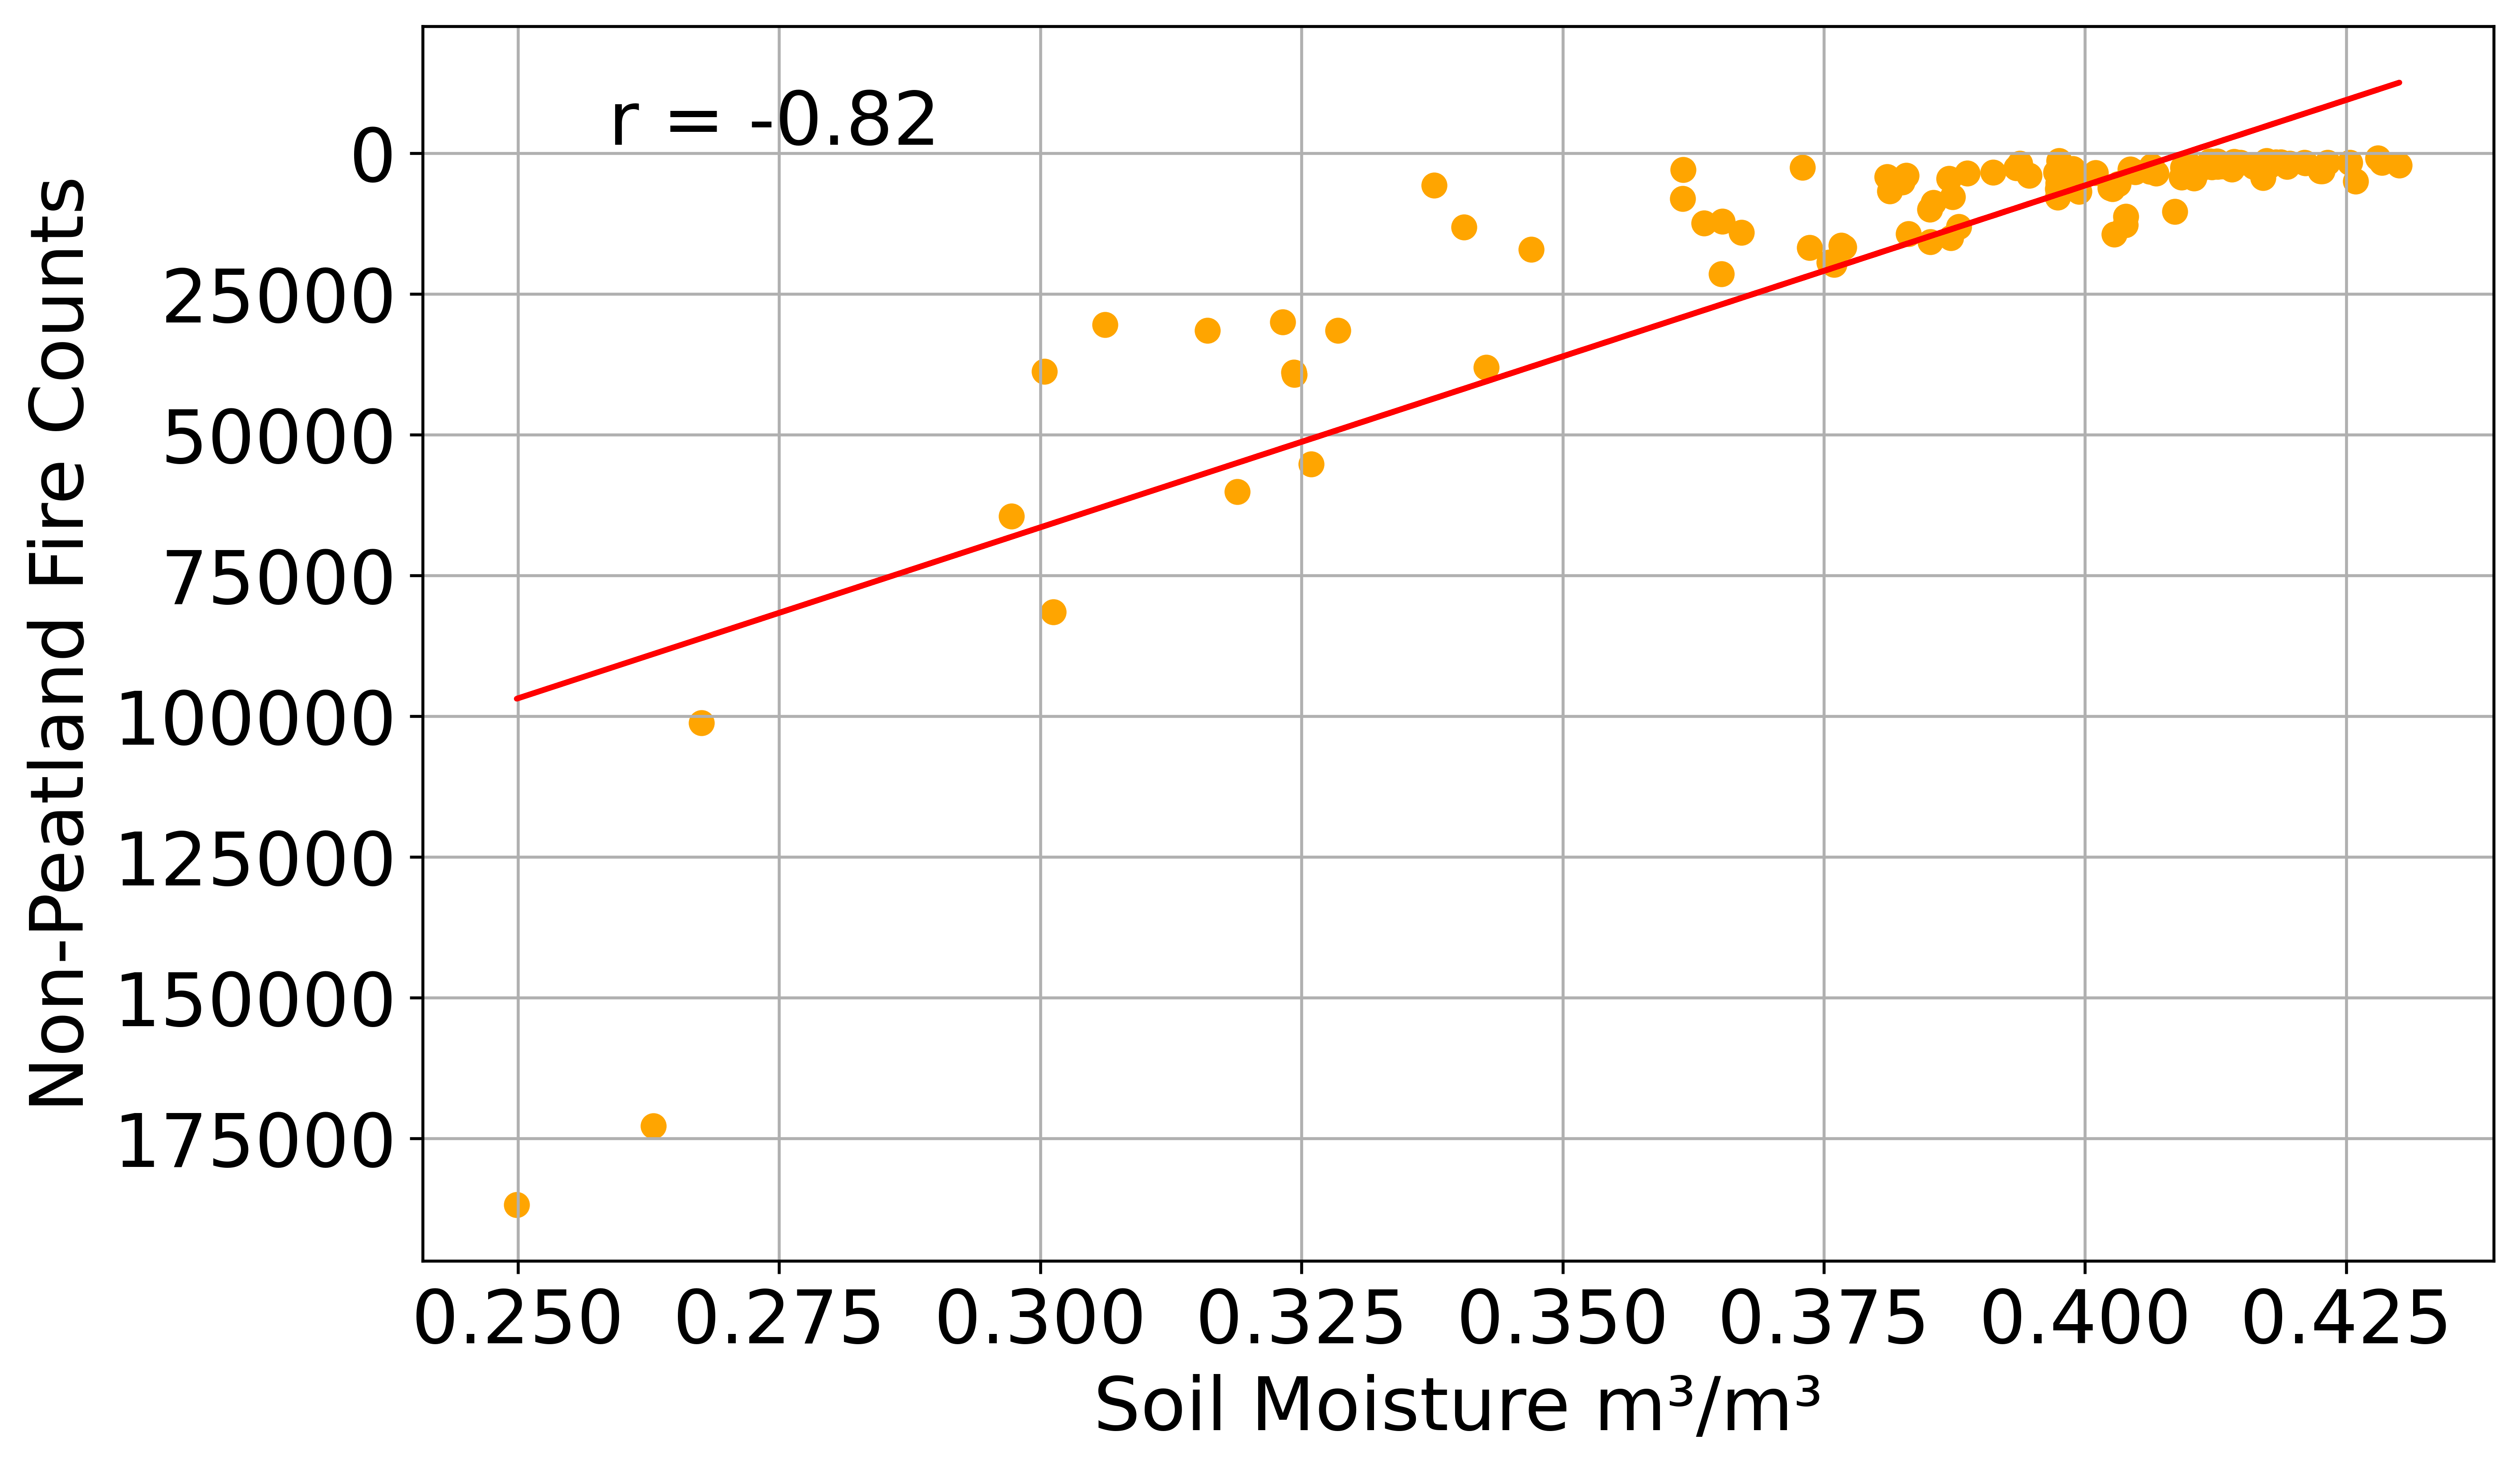

In [4]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# 1. 加载Excel数据
peatland_df = pd.read_excel('non peatland.xlsx')

# 2. 清理和处理VIIRS数据
peatland_df.columns = ['Month', 'Fire Counts', 'Total FRP']
peatland_df['Month'] = pd.to_datetime(peatland_df['Month'], format='%m-%Y')
peatland_df.set_index('Month', inplace=True)
peatland_df = peatland_df.astype(float)

# 从2015年7月开始筛选VIIRS数据
peatland_df_filtered = peatland_df[peatland_df.index >= '2015-06']

# 加载并处理SMAP数据，获取印度尼西亚地区的月平均土壤湿度
smap_ds = xr.open_dataset('SMAP_monthly_mean_soil_moisture_indonesia.nc')
smap_data = smap_ds['soil_moisture_monthly_mean_indonesia'].mean(dim=['lat', 'lon']).to_dataframe()

# 筛选SMAP数据，从2015年6月开始
smap_data_filtered = smap_data[smap_data.index >= '2015-06']

# 调整VIIRS的时间索引到每月月底，以匹配SMAP数据
peatland_df_filtered.index = peatland_df_filtered.index + pd.offsets.MonthEnd(0)

# 重新对齐两个数据集
aligned_peatland_smap_corrected = pd.merge(smap_data_filtered, peatland_df_filtered[['Fire Counts']], left_index=True, right_index=True)

# 计算皮尔逊相关系数
pearson_corr, _ = pearsonr(aligned_peatland_smap_corrected['soil_moisture_monthly_mean_indonesia'], aligned_peatland_smap_corrected['Fire Counts'])

# 进行线性回归
slope_corrected, intercept_corrected, r_value_corrected, p_value_corrected, std_err_corrected = linregress(
    aligned_peatland_smap_corrected['soil_moisture_monthly_mean_indonesia'], 
    aligned_peatland_smap_corrected['Fire Counts']
)
    
# 画出散点图和回归线
plt.figure(figsize=(10, 6), dpi=600)
plt.scatter(aligned_peatland_smap_corrected['soil_moisture_monthly_mean_indonesia'], aligned_peatland_smap_corrected['Fire Counts'], color='orange', label='Data Points')
plt.plot(aligned_peatland_smap_corrected['soil_moisture_monthly_mean_indonesia'], 
         slope_corrected * aligned_peatland_smap_corrected['soil_moisture_monthly_mean_indonesia'] + intercept_corrected, 
         color='red', 
         label=f'Regression Line (Pearson r={pearson_corr:.2f})')

# 添加皮尔逊相关系数文本
plt.text(
    0.25, 0.95, f'r = {pearson_corr:.2f}', 
    horizontalalignment='right', 
    verticalalignment='top', 
    transform=plt.gca().transAxes,
    fontsize=20, 
    bbox=dict(facecolor='none', alpha=0.5, edgecolor='none')
)

plt.xlabel('Soil Moisture m³/m³', fontsize=20)
plt.ylabel('Non-Peatland Fire Counts', fontsize=20)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()  # 反转Y轴
plt.grid(True)
plt.savefig('F6d.png', dpi=600, bbox_inches='tight')
plt.show()
